In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import random as rn

2023-11-23 15:24:08.382167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mellitaangga/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
train_pca = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree = pd.read_csv('Datasets/Tree_test_data.csv')

train_data = pd.read_csv('Datasets/train_dataset.csv')
test_data = pd.read_csv('Datasets/test_dataset.csv')

In [4]:
train_xformed = train_data.copy().drop(columns =["attack"])
test_xformed = test_data.copy().drop(columns =["attack"])

In [5]:
train_xformed.columns

Index(['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
       'is_guest_login', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0',
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'service_encoded_freq', 'attack_category', 'is_attack',
       'duration_scaled', 'src_bytes_scaled', 'dst_bytes_scaled',
       'wrong_fragment_scaled', 'urgent_scaled', 'hot_scaled',
       'num_failed_logins_scaled', 'num_compromised_scaled',
       'num_file_creations_scaled', 'num_shells_scaled',
       'num_access_files_scaled', 'count_scaled', 'srv_count_scaled',
       'same_srv_rate_scaled', 'diff_srv_rate_scaled',
       'srv_diff_host_rate_scaled', 'dst_host_count_scaled',
       'dst_host_srv_count_scaled', 'dst_host_same_srv_rate_scaled',
       'dst_host_diff_srv_rate_scaled', 'dst_host_same_src_port_rate_scaled',
       'dst_host_srv_diff_host_rate_scaled', 'se

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Initialize One-Hot Encoder
encoder = OneHotEncoder(handle_unknown="ignore")

## Protocol type
# Fit encoder on training data (returns a separate DataFrame)
data_ohe = pd.DataFrame(encoder.fit_transform(train_xformed[["service_encoded_freq"]]).toarray())
data_ohe.columns = [("service" + str(col)) for col in encoder.categories_[0]]

# Join encoded data with original training data
train_xformed = pd.concat([train_xformed, data_ohe], axis=1)
train_xformed.drop(columns=['service_encoded_freq'], inplace=True)

# Transform test data (returns a separate DataFrame)
data_ohe = pd.DataFrame(encoder.transform(test_xformed[["service_encoded_freq"]]).toarray())
data_ohe.columns = [("service" + str(col)) for col in encoder.categories_[0]]

# Join encoded data with original test data
test_xformed = pd.concat([test_xformed, data_ohe], axis=1)
test_xformed.drop(columns=['service_encoded_freq'], inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

train_df = train_xformed
test_df = test_xformed

normal = train_df[train_df['is_attack'] == 0]
attack = test_df[test_df['is_attack'] == 1]

# shuffle training data
normal = normal.sample(frac=1).reset_index(drop=True)

X_train = normal.drop(columns = ['is_attack', 'attack_category'])

X_train, X_validate = train_test_split(X_train, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED)

X_all, y_all, attack_cat_all = train_df.drop(columns=['is_attack', 'attack_category']), train_df['is_attack'], train_df['attack_category']

X_test, y_test, attack_cat = test_df.drop(columns=['is_attack', 'attack_category']), test_data['is_attack'], test_data['attack_category']



In [8]:
print(f"""samples in the test datasets:
    normal (rows, cols) = {test_data[test_data['is_attack'] == 0].shape[0]}
    attack (rows, cols) = {test_data[test_data['is_attack'] == 1].shape[0]}""")

samples in the test datasets:
    normal (rows, cols) = 9711
    attack (rows, cols) = 12833


In [9]:
print(f"""Shape of the datasets:
    training (non-attack)(rows, cols) = {X_train.shape}
    validate (non-attack)(rows, cols) = {X_validate.shape}
    validate2 (mix)    (rows, cols) = {X_all.shape}
    holdout  (mix)       (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (non-attack)(rows, cols) = (53874, 110)
    validate (non-attack)(rows, cols) = (13469, 110)
    validate2 (mix)    (rows, cols) = (125973, 110)
    holdout  (mix)       (rows, cols) = (22544, 110)


In [10]:
input_dim = X_train.shape[1]
BATCH_SIZE = 100
EPOCHS = 50

autoencoder2 = tf.keras.models.Sequential([
    # deconstruct / encode
    tf.keras.layers.Dropout(.5, input_shape=(input_dim,)),
    tf.keras.layers.Dense(8, activation='relu', activity_regularizer=tf.keras.regularizers.l2(10e-5)),

    # reconstruction / decode
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

autoencoder2.compile(optimizer="adam", 
                    loss="mse")

# print an overview of our model
autoencoder2.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 110)               0         
                                                                 
 dense (Dense)               (None, 8)                 888       
                                                                 
 dense_1 (Dense)             (None, 110)               990       
                                                                 
Total params: 1878 (7.34 KB)
Trainable params: 1878 (7.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

cb = [early_stop,]

In [12]:
auto_history2 = autoencoder2.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate, X_validate),
    callbacks = cb
);

Epoch 1/50
539/539 [==============================] - 2s 3ms/step - loss: 0.0308 - val_loss: 0.0128
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0113
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0108
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0103
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0100
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 8/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0095

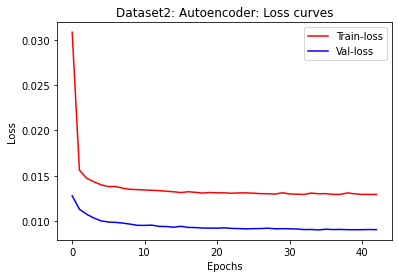

In [13]:
plt.plot( auto_history2.history['loss'],'r', label='Train-loss')
plt.plot( auto_history2.history['val_loss'],'b', label='Val-loss')
plt.title('Dataset2: Autoencoder: Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

3937/3937 [==============================] - 4s 1ms/step


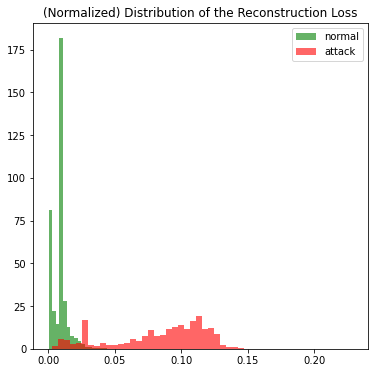

In [14]:
reconstructions_train = autoencoder2.predict(X_all)
mse_train = np.mean(np.power(X_all - reconstructions_train, 2), axis=1)

normal_train = mse_train[y_all==0]
attack_train = mse_train[y_all==1]

normal_train = [x for x in normal_train if x < 100]
attack_train = [x for x in attack_train if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_train, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_train, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, classification_report, f1_score)

def classify(THRESHOLD, mse, y):
    m = np.median(mse)
    ad = np.abs(mse - m)
    mad = np.median(ad)
    z_scores = 0.6745 * ad / mad
    
    outliers = z_scores > THRESHOLD
    mse_threshold = m + THRESHOLD * mad / 0.6745 
    
    print(f"Detected {np.sum(outliers):,} intrusions in a total of {np.size(z_scores):,} events [{np.sum(outliers)/np.size(z_scores):.2%}].")

    # get (mis)classification
    cm = confusion_matrix(y, outliers)

    # true/false positives/negativesb
    (tn, fp, 
     fn, tp) = cm.flatten()
    
    print( f"""threshold={THRESHOLD} result matrix:
    {cm}

    % of events labeled as intrusion that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
    % of intrusion were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
    
    print(classification_report(y, outliers))
    print("F1 score : " + str(f1_score(y, outliers)))
    
    return outliers, mse_threshold
    

In [16]:
def classify_v2(THRESHOLD, mse, y):
    outliers = mse > THRESHOLD

    print(f"Detected {np.sum(outliers):,} intrusions in a total of {np.size(mse):,} events [{np.sum(outliers)/np.size(mse):.2%}].")

    # get (mis)classification
    cm = confusion_matrix(y, outliers)

    # true/false positives/negativesb
    (tn, fp, 
     fn, tp) = cm.flatten()
    
    print( f"""threshold={THRESHOLD} result matrix:
    {cm}

    % of events labeled as intrusion that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
    % of intrusion were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
    
    print(classification_report(y, outliers))
    print("F1 score : " + str(f1_score(y, outliers)))
    
    return outliers 

In [17]:
predicted_train, mse_threshold_train = classify(1, mse_train, y_all)

Detected 49,388 intrusions in a total of 125,973 events [39.21%].
The classifications using the MAD method with threshold=1 are as follows:
    [[66876   467]
 [ 9709 48921]]

    % of events labeled as intrusion that were correct (precision): 48921/(467+48921) = 99.05%
    % of intrusion were caught succesfully (recall):    48921/(9709+48921) = 83.44%
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     67343
         1.0       0.99      0.83      0.91     58630

    accuracy                           0.92    125973
   macro avg       0.93      0.91      0.92    125973
weighted avg       0.93      0.92      0.92    125973

F1 score : 0.9057934788646337


In [18]:
predicted_train2 = classify_v2(auto_history2.history['loss'][-1], mse_train, y_all)

Detected 64,493 intrusions in a total of 125,973 events [51.20%].
The classifications using the MAD method with threshold=0.012943631038069725 are as follows:
    [[59218  8125]
 [ 2262 56368]]

    % of events labeled as intrusion that were correct (precision): 56368/(8125+56368) = 87.40%
    % of intrusion were caught succesfully (recall):    56368/(2262+56368) = 96.14%
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     67343
         1.0       0.87      0.96      0.92     58630

    accuracy                           0.92    125973
   macro avg       0.92      0.92      0.92    125973
weighted avg       0.92      0.92      0.92    125973

F1 score : 0.9156372083201352


In [19]:
train_df['predicted_intrusion'] = predicted_train
train_df['predicted_intrusion2'] = predicted_train2
train_df['mse'] = mse_train
train_df['predicted_intrusion'] = train_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)
train_df['predicted_intrusion2'] = train_df['predicted_intrusion2'].apply(lambda x: 1 if x == True else 0)

In [20]:
train_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      66876
                 1                        467
1                0                       2792
                 1                      43135
2                0                       5942
                 1                       5714
3                0                        927
                 1                         68
4                0                         48
                 1                          4
Name: count_scaled, dtype: int64

In [21]:
train_df.groupby(['attack_category', 'predicted_intrusion2'])['count_scaled'].count()

attack_category  predicted_intrusion2
0                0                       59218
                 1                        8125
1                0                         481
                 1                       45446
2                0                         963
                 1                       10693
3                0                         808
                 1                         187
4                0                          10
                 1                          42
Name: count_scaled, dtype: int64

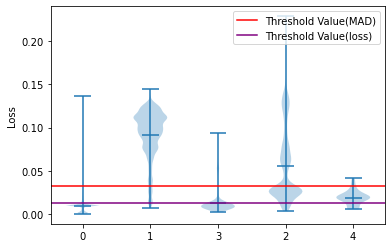

In [22]:
classes = train_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([train_df[train_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_train,c='r',label="Threshold Value(MAD)")
plt.axhline(y=auto_history2.history['loss'][-1],c='purple',label="Threshold Value(loss)")
plt.legend();

In [23]:
reconstructions_test = autoencoder2.predict(X_test)

705/705 [==============================] - 1s 1ms/step


In [24]:
mse_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

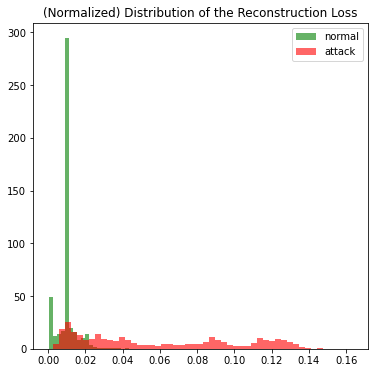

In [25]:
normal_test = mse_test[y_test==0]
attack_test = mse_test[y_test==1]

normal_test = [x for x in normal_test if x < 100]
attack_test = [x for x in attack_test if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_test, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_test, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [26]:
predicted_test, mse_threshold_test = classify(1, mse_test, y_test)

Detected 9,877 intrusions in a total of 22,544 events [43.81%].
The classifications using the MAD method with threshold=1 are as follows:
    [[8435 1276]
 [4232 8601]]

    % of events labeled as intrusion that were correct (precision): 8601/(1276+8601) = 87.08%
    % of intrusion were caught succesfully (recall):    8601/(4232+8601) = 67.02%
              precision    recall  f1-score   support

         0.0       0.67      0.87      0.75      9711
         1.0       0.87      0.67      0.76     12833

    accuracy                           0.76     22544
   macro avg       0.77      0.77      0.76     22544
weighted avg       0.78      0.76      0.76     22544

F1 score : 0.7574636723910171


In [27]:
predicted_test2 = classify_v2(auto_history2.history['loss'][-1], mse_test, y_test)

Detected 11,912 intrusions in a total of 22,544 events [52.84%].
The classifications using the MAD method with threshold=0.012943631038069725 are as follows:
    [[ 8474  1237]
 [ 2158 10675]]

    % of events labeled as intrusion that were correct (precision): 10675/(1237+10675) = 89.62%
    % of intrusion were caught succesfully (recall):    10675/(2158+10675) = 83.18%
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      9711
         1.0       0.90      0.83      0.86     12833

    accuracy                           0.85     22544
   macro avg       0.85      0.85      0.85     22544
weighted avg       0.85      0.85      0.85     22544

F1 score : 0.8628005657708628


In [28]:
test_df['predicted_intrusion'] = predicted_test
test_df['predicted_intrusion2'] = predicted_test2
test_df['mse'] = mse_test
test_df['predicted_intrusion'] = test_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)
test_df['predicted_intrusion2'] = test_df['predicted_intrusion2'].apply(lambda x: 1 if x == True else 0)

In [29]:
test_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      8435
                 1                      1276
1                0                       965
                 1                      6495
2                0                       502
                 1                      1919
3                0                      2706
                 1                       179
4                0                        59
                 1                         8
Name: count_scaled, dtype: int64

In [30]:
test_df.groupby(['attack_category', 'predicted_intrusion2'])['count_scaled'].count()

attack_category  predicted_intrusion2
0                0                       8474
                 1                       1237
1                0                        568
                 1                       6892
2                0                         71
                 1                       2350
3                0                       1503
                 1                       1382
4                0                         16
                 1                         51
Name: count_scaled, dtype: int64

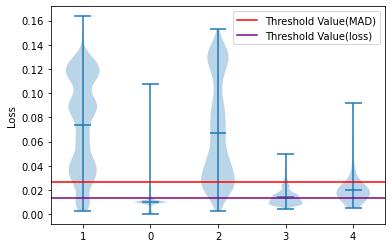

In [31]:
classes = test_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([test_df[test_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_test,c='r',label="Threshold Value(MAD)")
plt.axhline(y=auto_history2.history['loss'][-1],c='purple',label="Threshold Value(loss)")
plt.legend();

In [33]:
encoder = tf.keras.models.Sequential(autoencoder2.layers[:2])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 110)               0         
                                                                 
 dense (Dense)               (None, 8)                 888       
                                                                 
Total params: 888 (3.47 KB)
Trainable params: 888 (3.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
latent_representation = encoder.predict(X_all)

3937/3937 [==============================] - 4s 968us/step


In [35]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='TSNE.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(10,10))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='dos'
    )
    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==2)]),
        marker='o',
        color='orange',
        s=2,
        alpha=0.7,
        label='probe'
    )
    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==3)]),
        marker='o',
        color='b',
        s=2,
        alpha=0.7,
        label='R2L'
    )
    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==4)]),
        marker='o',
        color='m',
        s=2,
        alpha=0.7,
        label='U2R'
    )
    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='normal'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

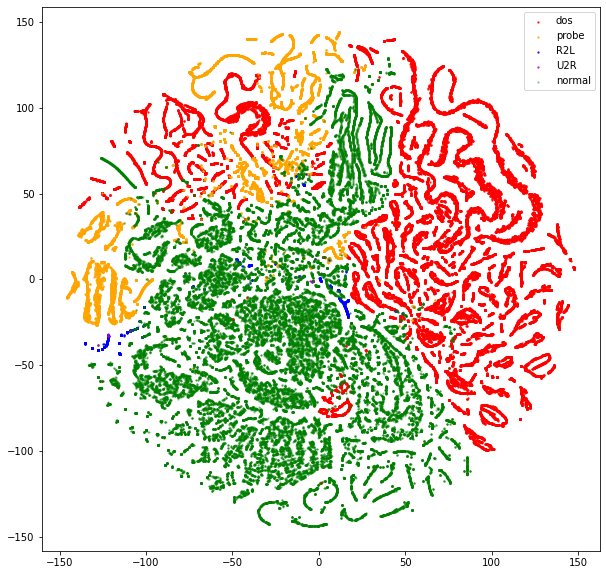

In [36]:
tsne_scatter(latent_representation, train_df['attack_category'], dimensions=2)